# Investigation

The API homepage lets you download CSVs of historical forecast and actual CI. These are (presumably) the final forecast values for the given time window. Here I check the forecast error.

In [1]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scrape.files import get_data_files
from scrape.graph import _ftime

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

# Get data files 2022-23
files = get_data_files("data/samples", extension=".csv")

df = pd.concat([pd.read_csv(fp, index_col=0) for fp in sorted(files)])

# Drop duplicates from overlapping dates
df = df[~df.index.duplicated(keep="last")]

df.index = pd.to_datetime(df.index)

In [2]:
df["error"] = df["Forecast Carbon Intensity (gCO2/kWh)"].sub(df["Actual Carbon Intensity (gCO2/kWh)"])
df["percentage error"] = 100. * df["error"].div(df["Actual Carbon Intensity (gCO2/kWh)"])
df.head()

,Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,error,percentage error
Datetime (UTC),,,,,
2022-01-01 00:00:00+00:00,71.0,83,low,12.0,16.901408
2022-01-01 00:30:00+00:00,74.0,74,low,0.0,0.000000
2022-01-01 01:00:00+00:00,75.0,70,low,-5.0,-6.666667
2022-01-01 01:30:00+00:00,73.0,70,low,-3.0,-4.109589
2022-01-01 02:00:00+00:00,68.0,61,low,-7.0,-10.294118


Text(0.5, 0.98, 'Percentage national forecast error, 21417 half-hour windows')

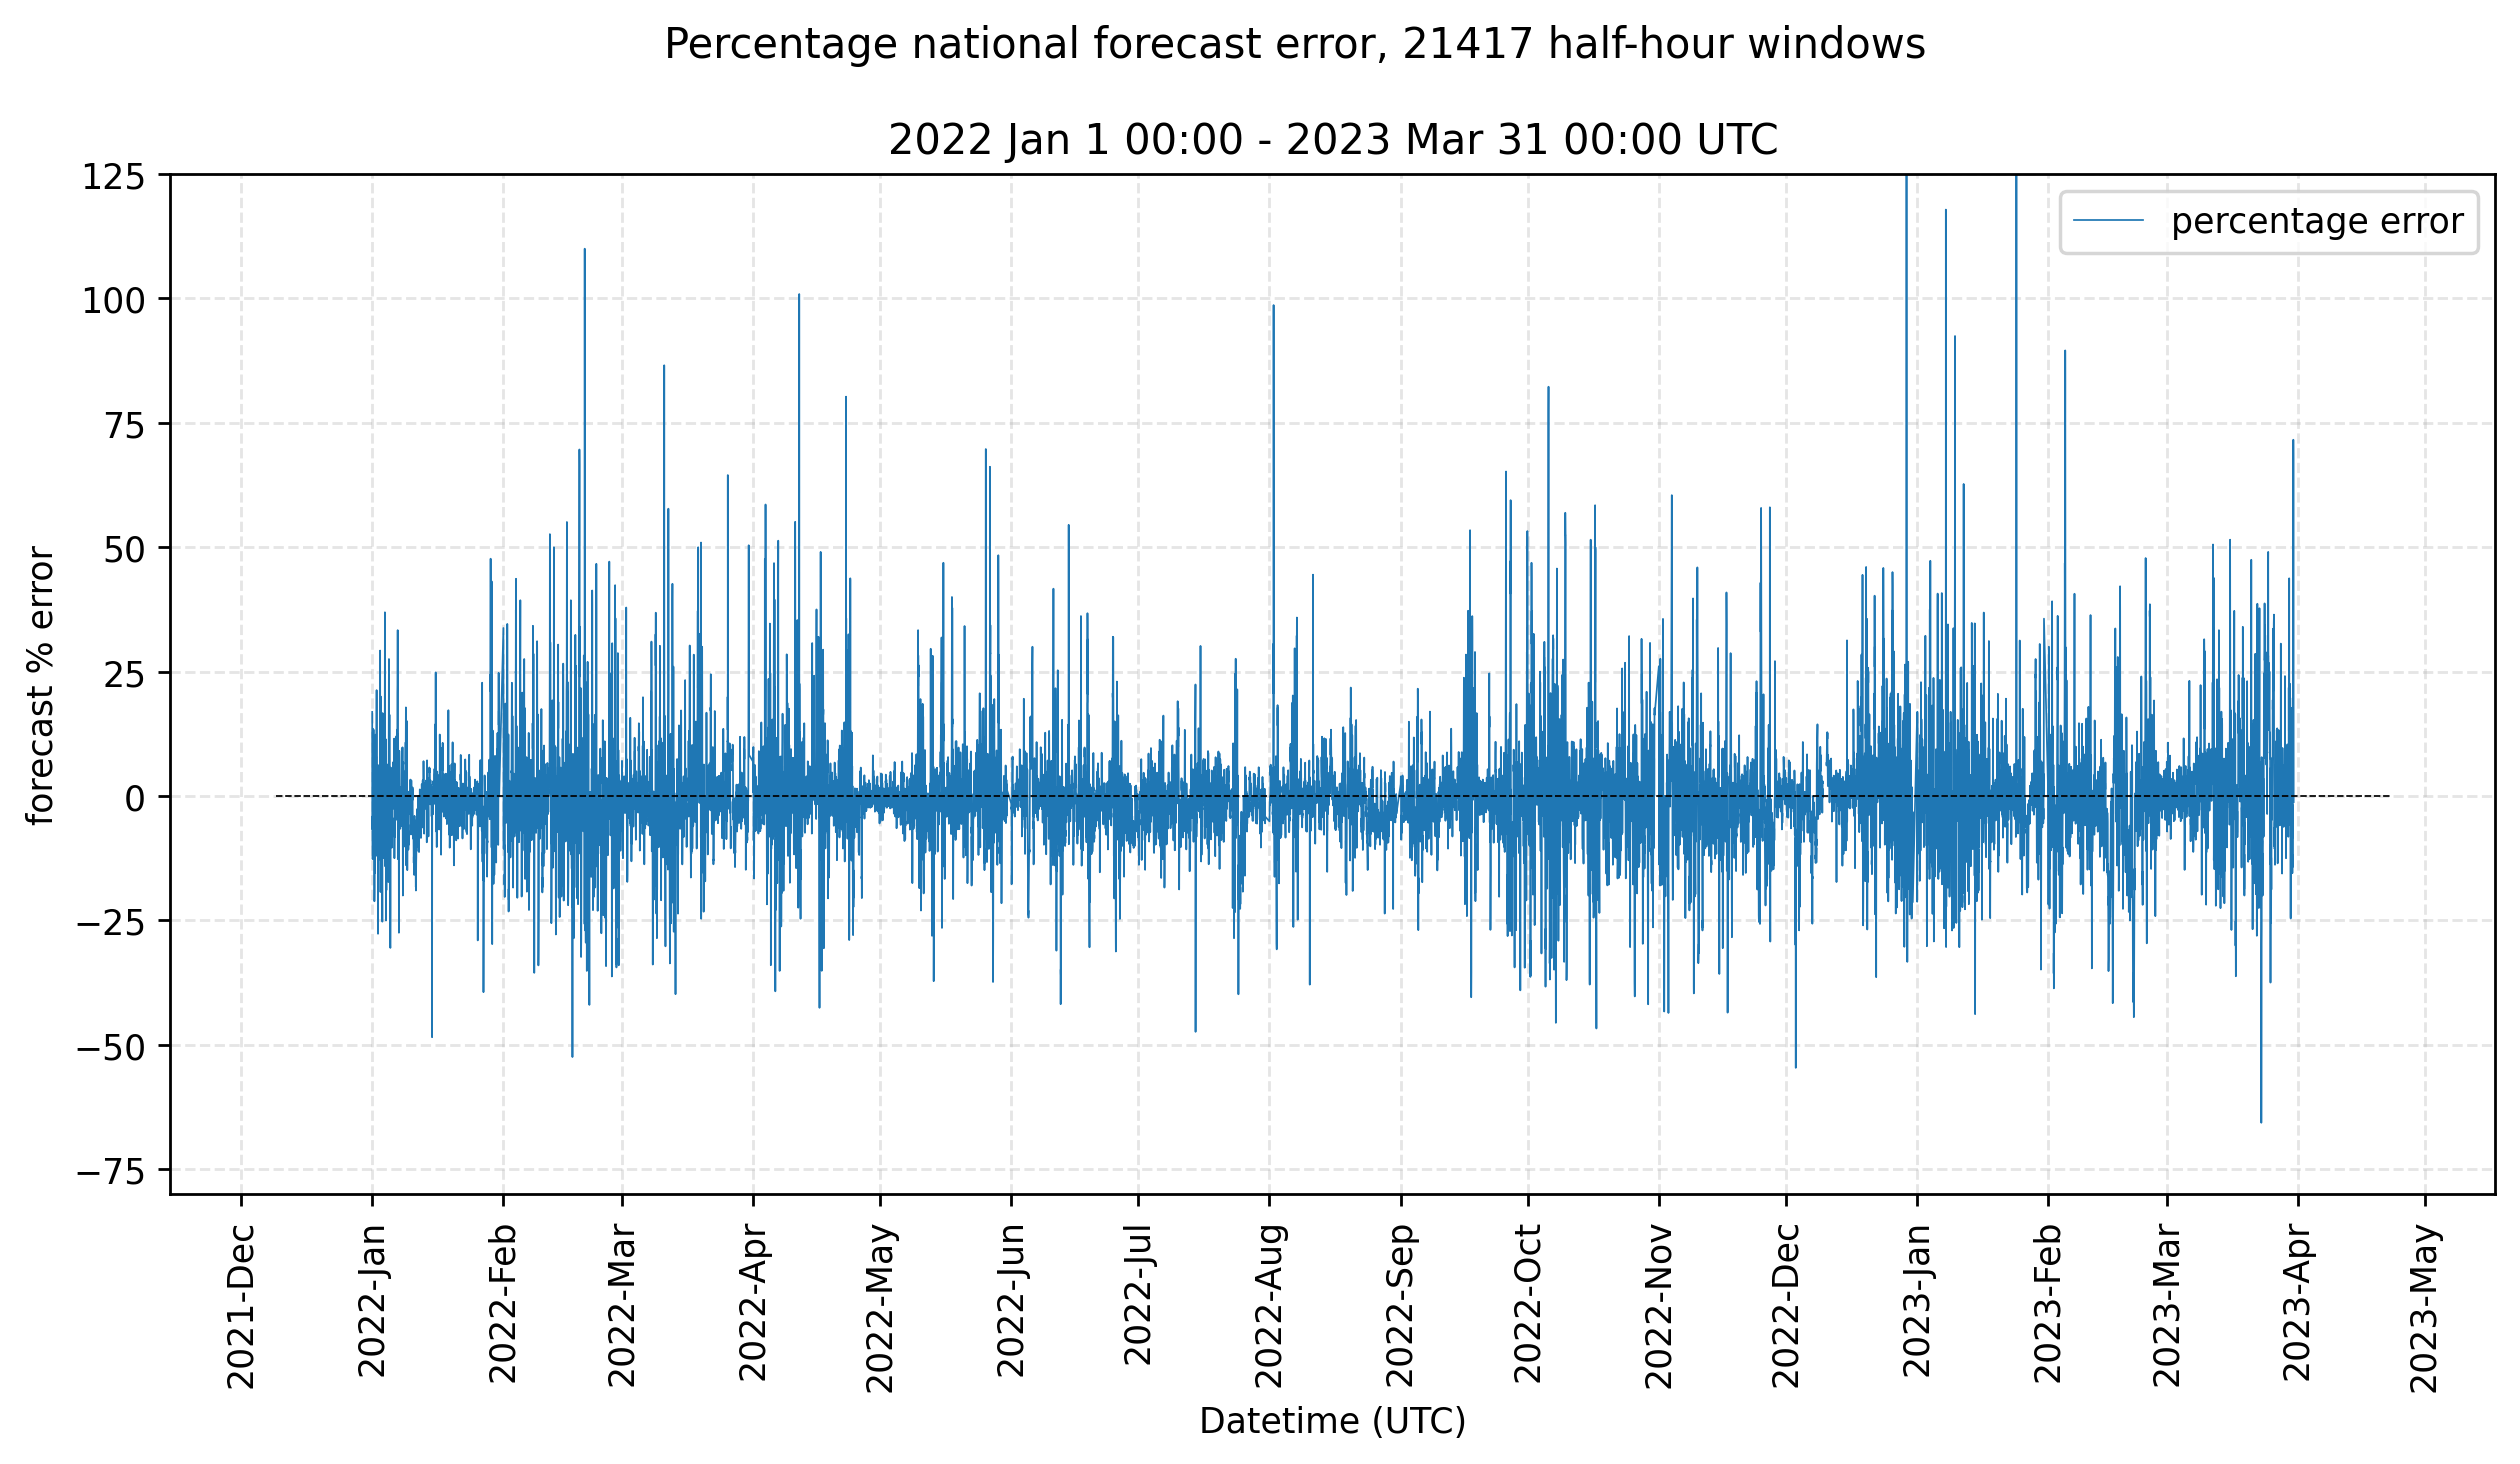

In [3]:
ax = df.plot(use_index=True, y="percentage error", linewidth=0.5, label=r"percentage error")

ax.set_ylim(-80,125)
ax.set_title(f"{_ftime(df.index[0])} - {_ftime(df.index[-1])} UTC")
ax.set_ylabel("forecast % error")
ax.grid("on", linestyle="--", alpha=0.33)
ax.hlines(
    0.0,
    ax.get_xlim()[0],
    ax.get_xlim()[-1],
    color="k",
    linestyle="--",
    linewidth=0.5,
)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()

ax.set_xticks(xticks, xlabels, rotation=90, ha="center")

locator = mdates.MonthLocator(interval=1)  # every month
fmt = mdates.DateFormatter("%Y-%b")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

fig = plt.gcf()
fig.suptitle(f"Percentage national forecast error, {len(df.index)} half-hour windows")

In [4]:
# The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
print(df["percentage error"].abs().mean(), df["percentage error"].std())

6.699429349210357 10.992827635927553


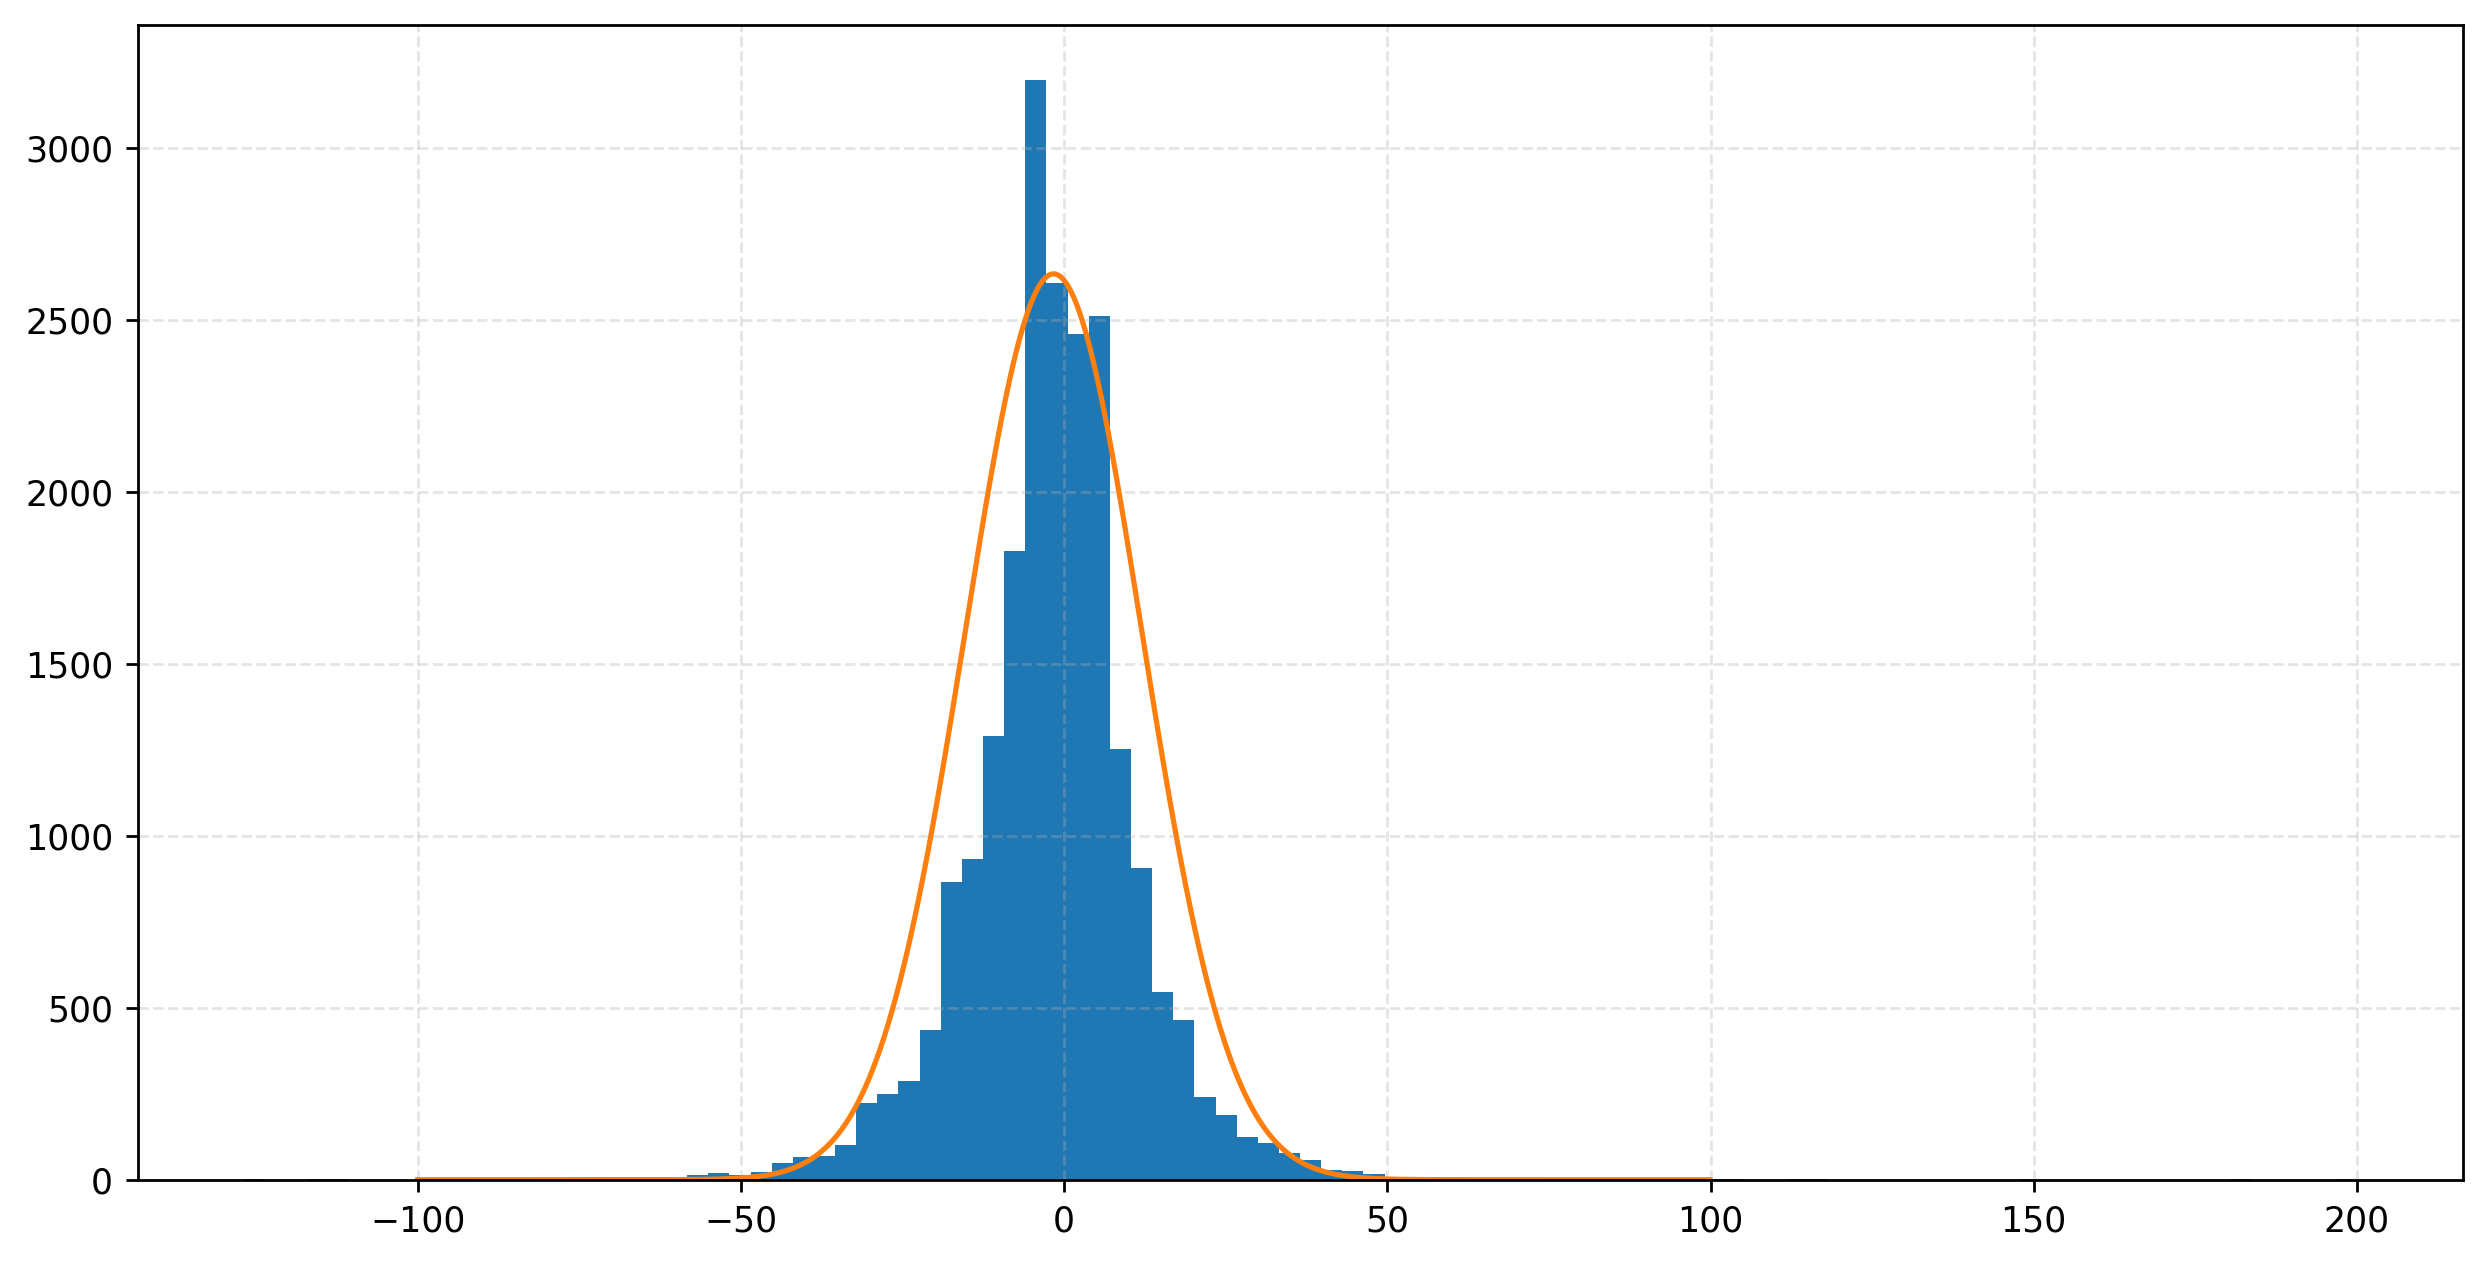

In [20]:
import numpy as np
from scipy import stats

ax = df["error"].hist(bins=100)
ax.grid("on", linestyle="--", alpha=0.33)

x = np.arange(-100, 100, 0.1)
y = stats.norm.pdf(x, df["error"].mean(), df["error"].std()) * 90000

ax.plot(x,y)

In [ ]:
df = pd.read_csv("data/artifacts/ci_index_numerical_bands.csv", index_col=0, header=[0,1])

cols = [(title, metric) for title in ["moderate - very low", "high - low", "very high - moderate"] for metric in ["difference", "percentage"]]

df_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df.index)

for ix, row in df.iterrows():    
    diff = row["moderate"]["from"] - row["very low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "percentage"]] = 100. * diff / row["moderate"]["from"]
    
    diff = row["high"]["from"] - row["low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["high - low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["high - low", "percentage"]] = 100. * diff / row["high"]["from"]
    
    diff = row["very high"]["from"] - row["moderate"]["to"]
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "percentage"]] = 100. * diff / row["very high"]["from"]

In [ ]:
df

In [ ]:
df_comp